<h1>Day 2: Hardware & Algorithms</h1>
<p><b>Workshop for the Computer Engineering Department, University of Tripoli</b></p>
<p><i>Prepared by Abdulmalek Baitulmal with Gemini</i></p>

## 🛠️ Setup: Installing Libraries

This cell will install the necessary libraries for today's session, including **`qiskit-dynamics`** for pulse-level simulation.

**Please run this cell and wait for the installation to complete before proceeding.**

In [ ]:
# Install the necessary libraries
!pip install -q qiskit qiskit-aer pylatexenc qiskit-dynamics

print("✅ Installation command executed.")
print("➡️ If you encounter any errors in the following cells, try restarting the kernel first (from the 'Kernel' menu).")

### Core Imports

Now we'll import all the tools we need for this session.

In [1]:
# Core Qiskit components
from qiskit import QuantumCircuit, pulse, transpile
from qiskit.pulse import Play, DriveChannel, Gaussian
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Operator

# Qiskit Dynamics for pulse simulation
from qiskit_dynamics import Solver
from qiskit_dynamics.pulse import InstructionToSignals

# Visualization tools
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Standard library for math
import numpy as np

# Let's check the version to confirm
import qiskit
print(f"Qiskit Version: {qiskit.__version__}")

Qiskit Version: 1.4.4


## Part 1: Hardware Deep Dive - The IBM Stack

### Hands-On: A Deeper Dive with Qiskit Dynamics

This example, adapted from the `qiskit-dynamics` tutorials, shows how to create a schedule for an SX-SY gate sequence using a DRAG pulse (designed to reduce errors) and simulate its effect on a qubit.

#### Step 1: Create the Pulse Schedule

In [ ]:
# Define physical parameters
r = 0.1  # Strength of the Rabi-rate in GHz.
w = 5.0  # Frequency of the qubit transition in GHz.
dt = 1 / 4.5  # Sample rate of the backend in ns.

# Define gaussian DRAG pulse parameters to approximately implement an sx gate.
amp = 1. / 1.75
sig = 0.6985 / r / amp
T = 4 * sig
duration = int(T / dt)
beta = 2.0

with pulse.build(name="sx-sy schedule") as sxsy_schedule:
    pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))
    pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
    pulse.play(pulse.Drag(duration, amp, sig / dt, beta), pulse.DriveChannel(0))

display(sxsy_schedule.draw())

#### Step 2: Convert the Pulse Schedule to a `Signal`

In [ ]:
plt.rcParams["font.size"] = 16
converter = InstructionToSignals(dt, carriers={"d0": w})
signals = converter.get_signals(sxsy_schedule)

fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))
for ax, title in zip(axs, ["envelope", "signal"]):
    signals[0].draw(0, 2*T, 2000, title, axis=ax)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.vlines(T, ax.get_ylim()[0], ax.get_ylim()[1], "k", linestyle="dashed")
plt.show()

#### Step 3: Create the System Model

In [ ]:
# Construct operators
X = Operator.from_label('X')
Z = Operator.from_label('Z')

drift = 2 * np.pi * w * Z/2
operators = [2 * np.pi * r * X/2]

# Construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=operators,
    rotating_frame=drift,
    rwa_cutoff_freq=2 * 5.0,
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': w},
    dt=dt
)

#### Step 4: Simulate the Pulse Schedule and Plot Results

In [ ]:
# Start the qubit in its ground state.
y0 = Statevector([1., 0.])

sol = hamiltonian_solver.solve(t_span=[0., 2*T], y0=y0, signals=sxsy_schedule, atol=1e-8, rtol=1e-8)

def plot_populations(sol):
    pop0 = [psi.probabilities()[0] for psi in sol.y]
    pop1 = [psi.probabilities()[1] for psi in sol.y]

    fig = plt.figure(figsize=(8, 5))
    plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
    plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
    plt.xlabel("Time (ns)")
    plt.ylabel("Population")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
    plt.xlim([0, 2*T])
    plt.vlines(T, 0, 1.05, "k", linestyle="dashed")
    plt.show()

plot_populations(sol)

---

## Part 2: From Hardware to Algorithms (FFT vs. QFT)

### The Quantum Fourier Transform (QFT)

The QFT's true power is revealing **periodicity** hidden in a quantum state. Let's prepare an input state with a hidden pattern: a superposition of $\ket{000}$ and $\ket{100}$. This state has a 'period' of 4. The QFT should find it.

Circuit for QFT on a periodic state:


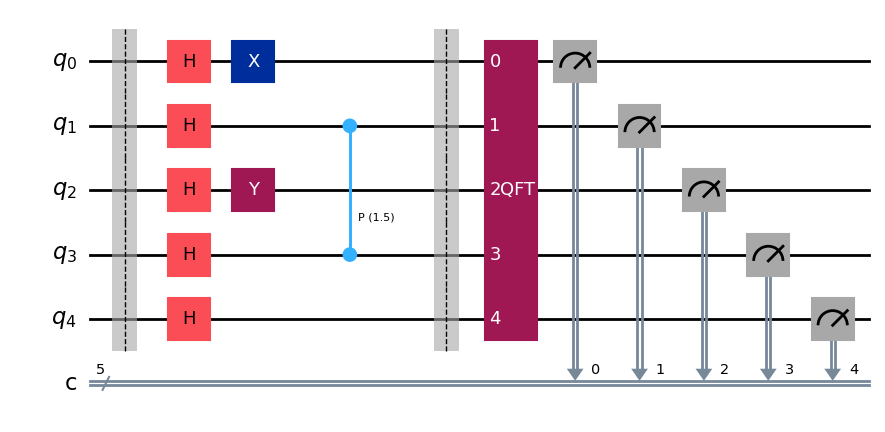


Applying QFT to the periodic state |000> + |100>:


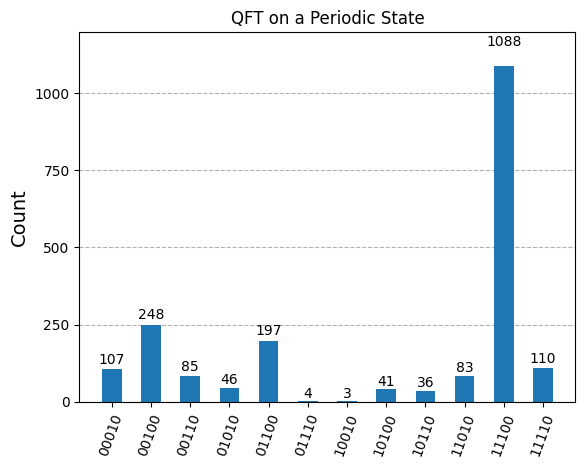


Observation: The results now show clear peaks at '000' (0) and '100' (4). This reveals the hidden period! This is the core mechanism behind Shor's algorithm.


In [14]:
from qiskit.circuit.library import QFT

# Create the circuit
n_qubits = 5
qc = QuantumCircuit(n_qubits, n_qubits)

# Prepare the periodic state: 1/sqrt(2) * (|000> + |100>)
# qc.h(2)
# qc.h(4)

qc.barrier()
for i in range(n_qubits):
    qc.h(i)


qc.y(2)
qc.x(0)
qc.cp(1.5, 3, 1)
qc.barrier()

# Apply the QFT using the circuit library
qft_gate = QFT(n_qubits, do_swaps=True, inverse=False, name='QFT')
qc.append(qft_gate, range(n_qubits))
qc.measure(range(n_qubits), range(n_qubits))

print("Circuit for QFT on a periodic state:")
display(qc.draw('mpl'))

# Initialize the simulator
simulator = AerSimulator()

# IMPORTANT: Transpile the circuit before running!
# This breaks down the high-level 'QFT' gate into basic gates the simulator understands.
transpiled_qc = transpile(qc, simulator)

# Run the transpiled circuit
job = simulator.run(transpiled_qc, shots=2048)
counts = job.result().get_counts()

print("\nApplying QFT to the periodic state |000> + |100>:")
display(plot_histogram(counts, title='QFT on a Periodic State'))
print("\nObservation: The results now show clear peaks at '000' (0) and '100' (4). This reveals the hidden period! This is the core mechanism behind Shor's algorithm.")

## End of Day 2

Today we went on a journey from the physical hardware that runs quantum computations all the way up to a foundational quantum algorithm. You've seen how abstract gates are just microwave pulses and how combining them in clever ways can lead to exponential speedups. Tomorrow, we'll explore the impact of these capabilities on AI and security.